Input:
- True Observations
- Number Training Steps

Output:
- New Model Parameter

Parts of Optimization:
- Initialization of Model Parameter
- tbd

# Initialization

## Import Libraries and Mount Drive

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import torch
from torch import distributions, optim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GitHub/master-thesis
import sys
sys.path.append('/content/gdrive/My Drive/GitHub/master-thesis')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GitHub/master-thesis


In [2]:
%cd ..

/home/anuar/PycharmProjects/master-thesis


In [3]:
from model.modelcore import epid_model
from model.modelhelper import *

## Optimization Settings

In [6]:
start_time='2020-02-26'
end_time='2020-09-30'
observations=['Confirmed_cases', 'Admissions_hospital'] # ['Number_of_deaths', 'Confirmed_cases', 'Admissions_hospital']

dtype = torch.float32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #cuda:0

## Initialize Observations

In [7]:
df_obs_initial = pd.read_csv('data/observations_03022022.csv' , sep=';', thousands='.', decimal=',', encoding='utf-8', parse_dates=['Date'])
df_obs = initialize_observations(df_obs_initial, start=start_time, end=end_time, observations=observations)
observed = torch.tensor(df_obs['Confirmed_cases'], requires_grad=False, device=device, dtype=dtype)
df_obs.head(3)

,Date,Confirmed_cases,Admissions_hospital
0,2020-02-26,1,0
1,2020-02-27,1,0
2,2020-02-28,1,0


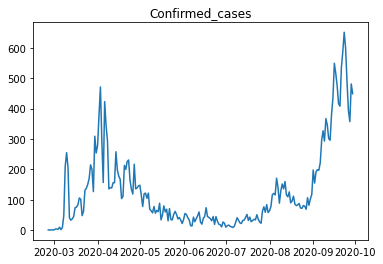

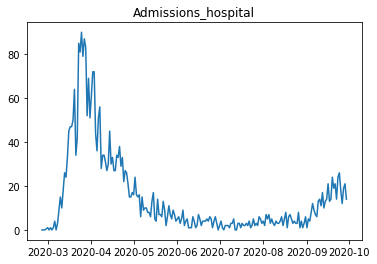

In [8]:
for observation in observations:
  plt.plot(df_obs['Date'], df_obs[observation])
  plt.title(observation)
  plt.show()

## Initialize Model Parameter

### Initialize Helper Parameter

In [9]:
cero = torch.tensor(0., requires_grad=False, device=device, dtype=dtype)
num_observations = df_obs.shape[0]
population = torch.tensor(5793636, requires_grad=False, device=device, dtype=dtype)

### Initialize to be optimized Model Parameter

In [10]:
parameter = ['alpha', 'sigma']
dict_param = initialize_parameter(parameter, device=device, dtype=dtype)

In [12]:
epsilon_t = initialize_epsilon(num_observations, dict_param['real_values']['sigma'], dtype=dtype, device=device)

# Optimization

## Training

Step: 0, Time: 26.343369483947754, Loss: 34920.421875, Mean Expected Daily Hospit: 0.3308727741241455


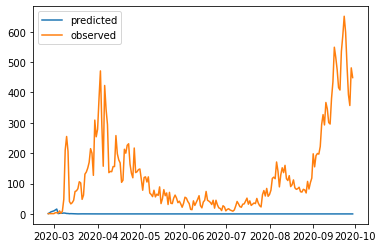

KeyboardInterrupt: 

In [13]:
epochs = 1000

params_to_be_optimized = [epsilon_t]
for param in parameter:
  params_to_be_optimized.append(dict_param['prime_values'][param])

optimizer = optim.Adam(params_to_be_optimized, lr=0.01, weight_decay=1e-8)

for i in range(epochs):
  start_time = time.time()
  optimizer.zero_grad()

  # forward pass
  transform_prime_variables(dict_param)
  expected = epid_model(population, R=torch.abs(epsilon_t), initial_newly_infected=np.arange(1, 18, 3), alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)['newly_infected']

  # calc loss
  comparison_loss = calc_mse(expected, observed)
  prior_loss = calc_prior_loss(dict_param, device=device, dtype=dtype)
  rw_loss = calc_random_walk_loss(epsilon_t, dict_param['real_values']['sigma'], device=device, dtype=dtype )
  loss = comparison_loss + prior_loss 

  # backward pass
  loss.backward()
  optimizer.step()

  if i % 5==0:
      print(f'Step: {i}, Time: {time.time() - start_time}, Loss: {loss}, Mean Expected Daily Hospit: {expected.cpu().detach().numpy().mean()}')
  
  if i % 50==0:
    plt.plot(df_obs['Date'], expected.cpu().detach().numpy(), label='predicted')
    plt.plot(df_obs['Date'], observed.cpu().detach().numpy(), label='observed')
    plt.legend()
    plt.show()


# Evaluation

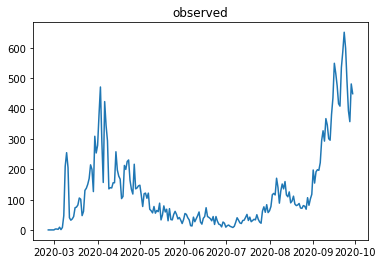

In [ ]:
plt.plot(df_obs['Date'], expected.cpu().detach().numpy(), label='predicted')
plt.plot(df_obs['Date'], observed.cpu().detach().numpy(), label='observed')
plt.legend()
plt.show()